In [95]:
import math
import re
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd


def parse_coordinates(coord_string):
    """
    Parse the latitude and longitude coordinates in the format: "24°29′23.7″N 120°40′16″E".
    Returns latitude and longitude in decimal degrees.
    """
    pattern = r'(\d+)°(\d+)′([\d.]+)″([NS])\s+(\d+)°(\d+)′([\d.]+)″([EW])'
    match = re.match(pattern, coord_string)
    
    if match:
        lat_deg = int(match.group(1))
        lat_min = int(match.group(2))
        lat_sec = float(match.group(3))
        lat_dir = match.group(4)
        lon_deg = int(match.group(5))
        lon_min = int(match.group(6))
        lon_sec = float(match.group(7))
        lon_dir = match.group(8)
        
        lat_decimal = lat_deg + lat_min/60 + lat_sec/3600
        if lat_dir == 'S':
            lat_decimal = -lat_decimal
            
        lon_decimal = lon_deg + lon_min/60 + lon_sec/3600
        if lon_dir == 'W':
            lon_decimal = -lon_decimal
            
        return lat_decimal, lon_decimal
    
    else:
        return None


# # Example usage
# coord_str = "23°12′29″N 119°25′43″E"

# # Parse latitude and longitude coordinates
# # latitude_str, longitude_str = coord_str.split()
# # latitude = parse_coordinates(latitude_str)
# # longitude = parse_coordinates(longitude_str)

# latitude, longitude = parse_coordinates_pair(coord_str)

# # Check if the coordinates were successfully parsed
# if latitude is not None and longitude is not None:
#     print("Latitude:", latitude)
#     print("Longitude:", longitude)
# else:
#     print("Invalid coordinate format")

# Rest of the code to calculate distance and find the nearest location goes here...

def calculate_distance(coords_1, coords_2):
    """
    Calculate the distance between two coordinates using the Haversine formula.
    """
    # print(coords_1, coords_2)
 
    lat1, lon1 = coords_1
    lat2, lon2 = coords_2
    
    
    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = 6371 * c  # Radius of the Earth in kilometers
    
    return distance

def find_nearest_location(target_coords, coordinates):
    """
    Find the nearest location to the target coordinate from a set of coordinates.
    """
        
    min_distance = float('inf')
    nearest_location = None
    
    for coords in coordinates:
        distance = calculate_distance(target_coords, coords)
        if distance < min_distance:
            min_distance = distance
            nearest_location = coords
    
    return nearest_location, min_distance

def get_target_distance(coords_series, target_coord):
    distance = np.zeros_like(coords_series.to_numpy(copy=True))
    for i, c in enumerate(coords_series):
        distance[i] = calculate_distance(c, target_coord)

    return distance


In [133]:
station_pos = pd.read_csv('.\\Station Locations.csv')
station_pos['Parsed Coords'] = station_pos.apply(lambda row: np.array((row['"twd97lat"'], row['"twd97lon"'])), axis=1)
# station_pos.head()

In [97]:
plant_pos = pd.read_csv('.\\Power Plant Locations.csv')
plant_pos['Parsed Coords'] = plant_pos['Coordinates'].apply(parse_coordinates)
# plant_pos.head()


In [1]:
import pandas as pd

# Define column names
column_names = ['power_plant_name', 'power_plant_latitude', 'power_plant_longitude', 
                'station_name', 'station_latitude', 'station_longitude']

# Load the data with column names
data = pd.read_csv('.\\Plant Station Locations.csv', header=None, names=column_names)

# Show the first few rows of the data
data.head()


,power_plant_name,power_plant_latitude,power_plant_longitude,station_name,station_latitude,station_longitude
0,和平電廠,24.306667,121.763889,冬山,24.632203,121.792928
1,興達發電廠,22.857222,120.196944,臺南,22.991230,120.220850
2,麥寮電廠,23.800000,120.183333,麥寮,23.753506,120.251825
3,台中發電廠,24.212778,120.481111,沙鹿,24.225628,120.568794
4,尖山發電廠,23.563056,119.661111,馬公,23.569031,119.566158


In [21]:
import pandas as pd

data = pd.read_csv('.\\Plant Station Location_20230723.csv')

In [39]:
import folium

# Create a Map instance
m = folium.Map(location=[23.6978, 120.9605], zoom_start=7)

# Add markers for power plants
for idx, row in data.iterrows():
    folium.Marker(
        location=[row['power_plant_latitude'], row['power_plant_longitude']],
        popup=row['power_plant_name_pinyin'],
        icon=folium.Icon(color="blue"),
    ).add_to(m)

# Add markers for stations
for idx, row in data.iterrows():
    folium.Marker(
        location=[row['station_latitude'], row['station_longitude']],
        popup=row['station_name_pinyin'],
        icon=folium.Icon(color="red"),
    ).add_to(m)

# Display the map
m.save('taiwan_map.html')


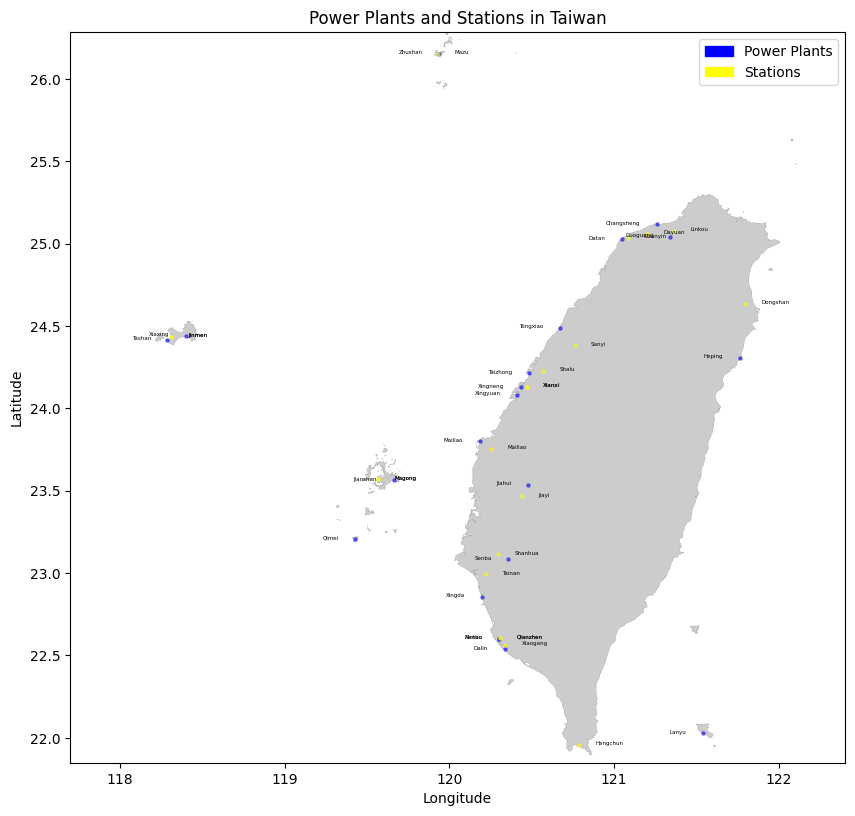

In [22]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches


# Load the map of Taiwan
# world = gpd.read_file(gpd.datasets.get_path('.\\TW Map\\gadm36_TWN_0.shp'))

# Subset to Taiwan
# taiwan = world[world.name == "Taiwan"]
taiwan = gpd.read_file('.\\TW Map\\gadm36_TWN_0.shp')

# Create a GeoDataFrame for power plants and stations
gdf_power_plants = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.power_plant_longitude, data.power_plant_latitude))
gdf_stations = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.station_longitude, data.station_latitude))

# Plot the map
fig, ax = plt.subplots(figsize=(10,10))
taiwan.plot(ax=ax, color='#CCCCCC', edgecolor='black', linewidth=0.05)
gdf_power_plants.plot(ax=ax, color='blue', alpha=0.5, markersize=5)
gdf_stations.plot(ax=ax, color='yellow', alpha=0.5, markersize=5)

# Annotate the power plants to the left of the marker
for x, y, label in zip(gdf_power_plants.geometry.x, gdf_power_plants.geometry.y, gdf_power_plants.power_plant_name_pinyin):
    ax.text(x - 0.1, y, label, fontsize=4, ha='right')

# Annotate the stations to the right of the marker
for x, y, label in zip(gdf_stations.geometry.x, gdf_stations.geometry.y, gdf_stations.station_name_pinyin):
    ax.text(x + 0.1, y, label, fontsize=4, ha='left')

# # Annotate the power plants with lines
# for x, y, label in zip(gdf_power_plants.geometry.x, gdf_power_plants.geometry.y, gdf_power_plants.power_plant_name_pinyin):
#     ax.annotate(label, (x, y), fontsize=4, ha='right', xytext=(-10, 5), textcoords='offset points', arrowprops=dict(arrowstyle='-', linestyle='-', color='black'))

# # Annotate the stations with lines
# for x, y, label in zip(gdf_stations.geometry.x, gdf_stations.geometry.y, gdf_stations.station_name_pinyin):
#     ax.annotate(label, (x, y), fontsize=4, ha='left', xytext=(10, 5), textcoords='offset points', arrowprops=dict(arrowstyle='-', linestyle='-', color='black'))


xmin, ymin, xmax, ymax = gpd.GeoSeries(pd.concat([gdf_power_plants.geometry, gdf_stations.geometry])).total_bounds
ax.set_xlim(xmin * 0.995, xmax * 1.005)
ax.set_ylim(ymin * 0.995, ymax * 1.005)

# Create the patches for the legend
blue_patch = mpatches.Patch(color='blue', label='Power Plants')
yellow_patch = mpatches.Patch(color='yellow', label='Stations')

ax.legend(handles=[blue_patch, yellow_patch])


# Set the plot title
plt.title("Power Plants and Stations in Taiwan")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()
fig.savefig('.\\map.png', dpi=600)


In [3]:
data['station_name'].head()

0    冬山
1    臺南
2    麥寮
3    沙鹿
4    馬公
Name: station_name, dtype: object

In [4]:
data_station_loc = pd.read_csv('.\\Station Locations.csv')
data_station_loc.head()

,"""sitename""","""siteengname""","""areaname""","""county""","""township""","""siteaddress""","""twd97lon""","""twd97lat""","""sitetype""","""siteid"""
0,基隆,Keelung,北部空品區,基隆市,信義區,基隆市東信路324號,121.760056,25.129167,一般站,1
1,汐止,Xizhi,北部空品區,新北市,汐止區,221新北市汐止區北市汐止區樟樹一路137巷26號,121.640810,25.066240,一般站,2
2,萬里,Wanli,北部空品區,新北市,萬里區,新北市萬里區瑪鋉路221號,121.689881,25.179667,一般站,3
3,新店,Xindian,北部空品區,新北市,新店區,新北市新店區民族路108號,121.537778,24.977222,一般站,4
4,土城,Tucheng,北部空品區,新北市,土城區,新北市土城區學府路一段241號,121.451861,24.982528,一般站,5


In [8]:
data_merged = data.merge(data_station_loc, how='left', right_on='"sitename"', left_on='station_name')
data_merged.head()

,power_plant_name,power_plant_name_pinyin,power_plant_latitude,power_plant_longitude,station_name,station_name_pinyin,station_latitude,station_longitude,distance_km,"""sitename""","""siteengname""","""areaname""","""county""","""township""","""siteaddress""","""twd97lon""","""twd97lat""","""sitetype""","""siteid"""
0,和平電廠,Heping,24.306667,121.763889,冬山,Dongshan,24.632203,121.792928,36.317102,冬山,Dongshan,宜蘭空品區,宜蘭縣,冬山鄉,宜蘭縣冬山鄉南興村照安路26號,121.792928,24.632203,一般站,66
1,興達發電廠,Xingda,22.857222,120.196944,臺南,Tainan,22.991230,120.220850,15.100769,臺南,Tainan,雲嘉南空品區,臺南市,東區,701台南市東區長榮路二段135號,120.220850,22.991230,一般站,46
2,麥寮電廠,Mailiao,23.800000,120.183333,麥寮,Mailiao,23.753506,120.251825,8.677671,麥寮,Mailiao,雲嘉南空品區,雲林縣,麥寮鄉,雲林縣麥寮鄉中興路115號,120.251825,23.753506,工業站,83
3,台中發電廠,Taizhong,24.212778,120.481111,沙鹿,Shalu,24.225628,120.568794,9.005811,沙鹿,Shalu,中部空品區,臺中市,沙鹿區,臺中市沙鹿區英才路150號,120.568794,24.225628,一般站,29
4,尖山發電廠,Jianshan,23.563056,119.661111,馬公,Magong,23.569031,119.566158,9.700521,馬公,Magong,其他,澎湖縣,馬公市,澎湖縣馬公市中正路115號,119.566158,23.569031,一般站,78


In [9]:
data_merged.to_csv('.\\Plant Station Location_20230812.csv')